# Install and import all libs

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pip install pandas
%pip install catboost
%pip install sklearn
%pip install numpy
%pip install matplotlib
%pip install seaborn
%pip install csv
%pip install joblib
%pip install scipy
%pip install h5py scikit-optimize
%pip install optuna
%pip install eli5
%pip install shap
%pip install mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=2ea886778c0762b0fa81ebd8c035ff3f7ae90333f13de196b0cbecfa766ddcee
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built sklearn
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-pyt

In [ ]:
import sys

import pandas as pd

import numpy as np

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

import shap

import csv

import joblib

sys.modules['sklearn.externals.joblib'] = joblib

import sklearn
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer , mean_squared_error, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn.feature_selection import RFE, SelectKBest, chi2, f_classif
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics.pairwise import cosine_similarity
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS


import optuna

from datetime import datetime

import math

import statistics

import lightgbm as lgbm

import catboost as cb
from catboost import CatBoostError

import eli5
from eli5.sklearn import PermutationImportance

import os
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

Что удалось сделать в результате работы

1) Смог проанализировать датасеты и очистил их от мусора

2) "Оптимизировал" датасеты различными путями

3) Построил графики визуализации, которые показывают картину происходящего

4) Обучил модели МО randomForest, Catboost и LightGBM

5) Использовал поиск гипер параметров с помощью Optuna

6) Провел кросс-валидацию Catboost и LightGBM

7) Попытался воспользоваться SHAP для отображения эффективности

8) Воспользовался Feature selection и wrapper method для перепроверки работоспособности моделей

Интересные случаи

Так как даже после merge-а у нас некоторые данные оставались нулевыми, я заполнял их из колонки persons (делал этим способом, так как так понял задание)

Чтобы проанализироать даты я воспользовался разделением на дни, месяцы и года. Так я точно убедился, что модель МО будет учитывать их при обучении

# Importing datasets

In [ ]:
action_test = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Sberseasons/action_test.csv') # 
action_test.drop('Unnamed: 0', axis=1, inplace=True)
print(action_test.shape)
action_test.head()

(498687, 14)


,person_id,action_id,date,action_type,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10
0,ppl_100004,act1_249281,2022-07-20,type 1,type 5,type 10,type 5,type 1,type 6,type 1,type 1,type 7,type 4,NaN
1,ppl_100004,act2_230855,2022-07-20,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 682
2,ppl_10001,act1_240724,2022-10-14,type 1,type 12,type 1,type 5,type 4,type 6,type 1,type 1,type 13,type 10,NaN
3,ppl_10001,act1_83552,2022-11-27,type 1,type 20,type 10,type 5,type 4,type 6,type 1,type 1,type 5,type 5,NaN
4,ppl_10001,act2_1043301,2022-10-15,type 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 3015


In [ ]:
action_train = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Sberseasons/action_train.csv' ) # , nrows=200_000
action_train.drop('Unnamed: 0', axis=1, inplace=True)
print(action_train.shape)
action_train.head()

Columns (5,6,7,8,9,10,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.


(2197291, 15)


,person_id,action_id,date,action_type,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,result
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 76,0
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
2,ppl_100,act2_3404049,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
3,ppl_100,act2_3651215,2023-08-04,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0
4,ppl_100,act2_4109017,2023-08-26,type 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,type 1,0


In [ ]:
person = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Sberseasons/person.csv') # перепроверить id на уникальность 
person.drop('Unnamed: 0', axis=1, inplace=True)
print(person.shape)
person.head()

(189118, 41)


,person_id,char_1,group_1,char_2,date,char_3,char_4,char_5,char_6,char_7,...,char_29,char_30,char_31,char_32,char_33,char_34,char_35,char_36,char_37,char_38
0,ppl_100,type 2,group 17304,type 2,2021-06-29,type 5,type 5,type 5,type 3,type 11,...,False,True,True,False,False,True,True,True,False,36
1,ppl_100002,type 2,group 8688,type 3,2021-01-06,type 28,type 9,type 5,type 3,type 11,...,False,True,True,True,True,True,True,True,False,76
2,ppl_100003,type 2,group 33592,type 3,2022-06-10,type 4,type 8,type 5,type 2,type 5,...,False,False,True,True,True,True,False,True,True,99
3,ppl_100004,type 2,group 22593,type 3,2022-07-20,type 40,type 25,type 9,type 4,type 16,...,True,True,True,True,True,True,True,True,True,76
4,ppl_100006,type 2,group 6534,type 3,2022-07-27,type 40,type 25,type 9,type 3,type 8,...,False,False,True,False,False,False,True,True,False,84


# Person analysis

### Первый взгялд на датасет

In [ ]:
person.describe()

,char_38
count,189118.000000
mean,50.327399
std,35.752127
min,0.000000
25%,10.000000
50%,58.000000
75%,83.000000
max,100.000000


In [ ]:
# У нас отсутствуют какие-либо NaN значения, что не может не радовать
person.isnull().sum().sum() 

0

In [ ]:
# Как мы видим, размер составляет больше 100 мб, поэтому давайте его сократим
person.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189118 entries, 0 to 189117
Data columns (total 41 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   person_id  189118 non-null  object
 1   char_1     189118 non-null  object
 2   group_1    189118 non-null  object
 3   char_2     189118 non-null  object
 4   date       189118 non-null  object
 5   char_3     189118 non-null  object
 6   char_4     189118 non-null  object
 7   char_5     189118 non-null  object
 8   char_6     189118 non-null  object
 9   char_7     189118 non-null  object
 10  char_8     189118 non-null  object
 11  char_9     189118 non-null  object
 12  char_10    189118 non-null  bool  
 13  char_11    189118 non-null  bool  
 14  char_12    189118 non-null  bool  
 15  char_13    189118 non-null  bool  
 16  char_14    189118 non-null  bool  
 17  char_15    189118 non-null  bool  
 18  char_16    189118 non-null  bool  
 19  char_17    189118 non-null  bool  
 20  char

## Dataset set categories


Наш датасет сейчас имеет объем выше 100 мб, что влияет на скорость его обработки и сказывается на самом размере. Почему это происходит ? Некоторые данные (как list, к примеру) могут есть больше памяти, чем на самом деле потребляют, но можно преобразовать данные к правильному формату, сделать их категориальными, тогда мы и сократим объем датасета (без потери данных) и ускорим скорость его обработки

In [ ]:
# каждый char мы сделали категориальным, так мы увеличили скорость обратоки нашего датасета
for i in range(1,10):
  person[f'char_{i}'] = person[f'char_{i}'].astype('category')


In [ ]:
# Тут мы приводим дату из формата string к datetime64
person['date'] = pd.to_datetime(person['date'])


In [ ]:
person.nunique()

person_id    189118
char_1            2
group_1       34224
char_2            3
date           1196
char_3           43
char_4           25
char_5            9
char_6            7
char_7           25
char_8            8
char_9            9
char_10           2
char_11           2
char_12           2
char_13           2
char_14           2
char_15           2
char_16           2
char_17           2
char_18           2
char_19           2
char_20           2
char_21           2
char_22           2
char_23           2
char_24           2
char_25           2
char_26           2
char_27           2
char_28           2
char_29           2
char_30           2
char_31           2
char_32           2
char_33           2
char_34           2
char_35           2
char_36           2
char_37           2
char_38         101
dtype: int64

In [ ]:
# Посмотрим как изменился размер нашего датасета
person.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189118 entries, 0 to 189117
Data columns (total 41 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   person_id  189118 non-null  object        
 1   char_1     189118 non-null  category      
 2   group_1    189118 non-null  object        
 3   char_2     189118 non-null  category      
 4   date       189118 non-null  datetime64[ns]
 5   char_3     189118 non-null  category      
 6   char_4     189118 non-null  category      
 7   char_5     189118 non-null  category      
 8   char_6     189118 non-null  category      
 9   char_7     189118 non-null  category      
 10  char_8     189118 non-null  category      
 11  char_9     189118 non-null  category      
 12  char_10    189118 non-null  bool          
 13  char_11    189118 non-null  bool          
 14  char_12    189118 non-null  bool          
 15  char_13    189118 non-null  bool          
 16  char_14    189118 no

Теперь, когда у нас не осталось нулевых значений и наш датасет стал "оптимизированнее", мы можем сделать визуализацию и приступить к другому датасету

## Dataset visual

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f15b42442e0>,
      dtype=object)

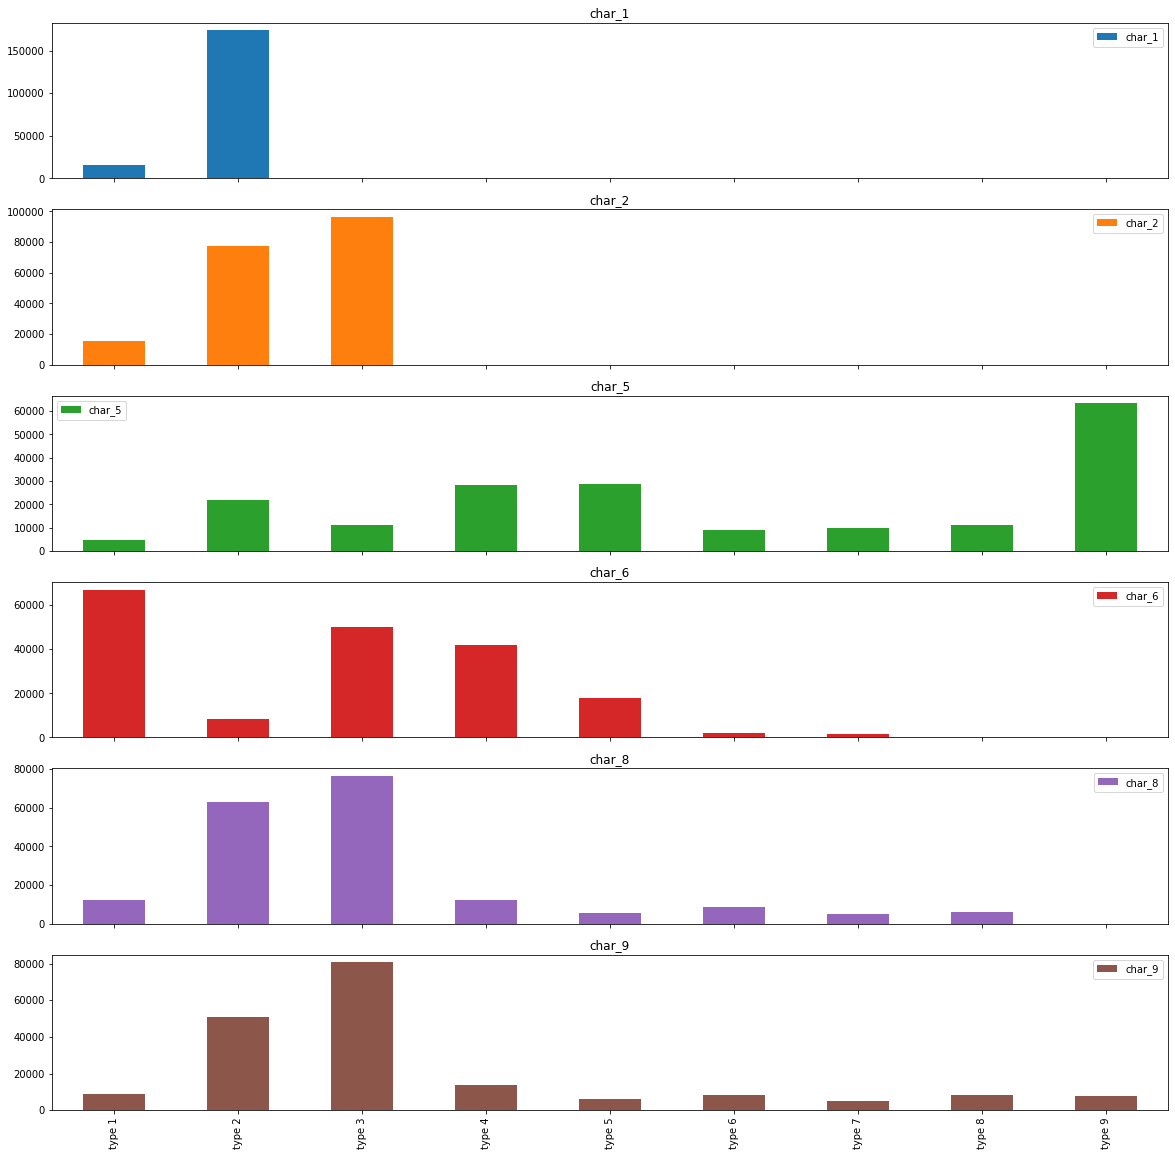

In [ ]:
person[['char_1','char_2','char_5','char_6','char_8','char_9']].apply(pd.value_counts).plot(kind='bar', subplots=True, figsize=(20,20))


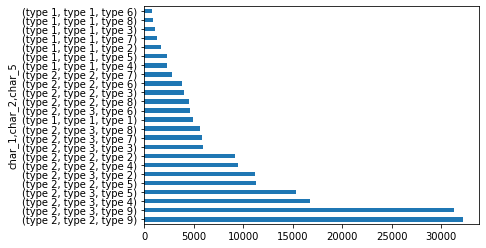

In [ ]:
person[['char_1','char_2','char_5']].value_counts().plot(kind="barh", fontsize=10)

# Action train analysis

### Первый взгялд на датасет

In [ ]:
action_train.describe()

,result
count,2.197291e+06
mean,4.439544e-01
std,4.968491e-01
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,1.000000e+00
max,1.000000e+00


In [ ]:
# Как мы видим, количество нулевых значений с char_1 по char_9 практически равно 90%
action_train.isnull().sum() 

person_id            0
action_id            0
date                 0
action_type          0
char_1         2039676
char_2         2039676
char_3         2039676
char_4         2039676
char_5         2039676
char_6         2039676
char_7         2039676
char_8         2039676
char_9         2039676
char_10         157615
result               0
dtype: int64

In [ ]:
# Не сложно заметить, что если округлить процент пропусков, то мы получим 93%, что явно нам не поможет и будет лишним для ML
action_train.isnull().sum()[5]/action_train.shape[0]

0.9282684906095733

### мердж action_train и person

In [ ]:
list_of_chars = ["char_1","char_2","char_3","char_4","char_5","char_6","char_7","char_8","char_9",'person_id']
df=action_train.merge(person[list_of_chars], on='person_id', how='inner')

In [ ]:
df

,person_id,action_id,date,action_type,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,...,result,char_1_y,char_2_y,char_3_y,char_4_y,char_5_y,char_6_y,char_7_y,char_8_y,char_9_y
0,ppl_100,act2_1734928,2023-08-26,type 4,NaN,NaN,NaN,NaN,NaN,NaN,...,0,type 2,type 2,type 5,type 5,type 5,type 3,type 11,type 2,type 2
1,ppl_100,act2_2434093,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,0,type 2,type 2,type 5,type 5,type 5,type 3,type 11,type 2,type 2
2,ppl_100,act2_3404049,2022-09-27,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,0,type 2,type 2,type 5,type 5,type 5,type 3,type 11,type 2,type 2
3,ppl_100,act2_3651215,2023-08-04,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,0,type 2,type 2,type 5,type 5,type 5,type 3,type 11,type 2,type 2
4,ppl_100,act2_4109017,2023-08-26,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,0,type 2,type 2,type 5,type 5,type 5,type 3,type 11,type 2,type 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197286,ppl_99994,act2_4668076,2023-06-16,type 4,NaN,NaN,NaN,NaN,NaN,NaN,...,1,type 2,type 3,type 2,type 7,type 2,type 1,type 2,type 2,type 2
2197287,ppl_99994,act2_4743548,2023-03-30,type 4,NaN,NaN,NaN,NaN,NaN,NaN,...,1,type 2,type 3,type 2,type 7,type 2,type 1,type 2,type 2,type 2
2197288,ppl_99994,act2_536973,2023-01-19,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,1,type 2,type 3,type 2,type 7,type 2,type 1,type 2,type 2,type 2
2197289,ppl_99994,act2_688656,2023-05-02,type 4,NaN,NaN,NaN,NaN,NaN,NaN,...,1,type 2,type 3,type 2,type 7,type 2,type 1,type 2,type 2,type 2


In [ ]:
df.isnull().sum() 

person_id            0
action_id            0
date                 0
action_type          0
char_1_x       2039676
char_2_x       2039676
char_3_x       2039676
char_4_x       2039676
char_5_x       2039676
char_6_x       2039676
char_7_x       2039676
char_8_x       2039676
char_9_x       2039676
char_10         157615
result               0
char_1_y             0
char_2_y             0
char_3_y             0
char_4_y             0
char_5_y             0
char_6_y             0
char_7_y             0
char_8_y             0
char_9_y             0
dtype: int64

In [ ]:
# уберем ненужный _x из наших колонок
df.columns = df.columns.str.replace('_x', '') 

In [ ]:
list_of_chars.pop()
for i in list_of_chars:
  df[i+""] = df[i+""].fillna(df[i+"_y"])

In [ ]:
# Избавимся от ненужных колонок, так как мы заполнили пропуски
df = df.iloc[: , :-9] 

In [ ]:
df.isnull().sum() 

person_id           0
action_id           0
date                0
action_type         0
char_1              0
char_2              0
char_3              0
char_4              0
char_5              0
char_6              0
char_7              0
char_8              0
char_9              0
char_10        157615
result              0
dtype: int64

In [ ]:
# Как мы видим, размер составляет больше 700 мб, поэтому давайте его сократим
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2197291 entries, 0 to 2197290
Data columns (total 15 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   person_id    object
 1   action_id    object
 2   date         object
 3   action_type  object
 4   char_1       object
 5   char_2       object
 6   char_3       object
 7   char_4       object
 8   char_5       object
 9   char_6       object
 10  char_7       object
 11  char_8       object
 12  char_9       object
 13  char_10      object
 14  result       int64 
dtypes: int64(1), object(14)
memory usage: 2.0 GB


## Dataset set categories


In [ ]:
# to category
df['action_type'] = df['action_type'].astype('category')
df['result'] = df['result'].astype('category')


In [ ]:
# to datetime
df['date'] = pd.to_datetime(df['date'])

In [ ]:
# Теперь,  чтобы избавиться от NaN мы заполним char_10 нулями
df["char_10"]=df["char_10"].fillna("type 0")

### Encoding data

In [ ]:
# Дабы избавиться от string значений, которые могут нам помешать, мы возьмем только числовые значения действий

def get_number_of_type(row):
  return row.split(" ")[1]

def get_number_and_act_of_action(row,idx):
  return row.split("_")[idx]

def get_number_of_person_id(row):
  return row.split("_")[1]

In [ ]:
# На данном шаге мы получаем только какой номер type у нас в колонке и записываем на это же место. Пример: (было) type 2	 -> (стало) 2
for i in range(1,11):
  df[f'char_{i}'] = df[f'char_{i}'].apply(get_number_of_type)
  df[f'char_{i}'] = df[f'char_{i}'].astype(float)

In [ ]:
# Здесь мы отбрасываем ppl_ так как нам важен id человека и стринговое значение может помешать анализу
df[f'person_id']=df['person_id'].apply(get_number_of_person_id)
df[f'person_id']=df['person_id'].astype('float')

Следующий шаг может вызвать вопросы, но давайте посмотрим для чего же это все нужно

На данном этапе совершается немного необычное действие. К примеру, мы разбиваем act2_1734928 на act2 и 1734928 . Сделано это для того, чтобы потом мы могли загнать эти данные в Encoder. Это может повлиять на производительность и на "точность" нашей модели

In [ ]:
df['act_type']=df['action_id'].apply(lambda x:get_number_and_act_of_action(x,0))
df['action_id']=df['action_id'].apply(lambda x:get_number_and_act_of_action(x,1))
df['action_id']= df['action_id'].astype('float')

Данный этап тоже стоит отдельного внимания... 

Дабы datetime тоже имел вес, его необходимо преобразовать, но, к сожалению, с форматом 2023-08-26 могут возникнуть проблемы, поэтому хорошей практикой считается использование методики разбиения на дни, месяцы и года, что здесь и выполняется !

In [ ]:
df['date']=pd.to_datetime(df['date'], format = '%Y-%m-%d')
timestemp_dt= df['date'].dt

df['day'] = timestemp_dt.day
df['month'] = timestemp_dt.month
df['year'] = timestemp_dt.year
df['difference_between_now_and_date'] = (datetime.today() - df['date']).dt.days

In [ ]:
df

,person_id,action_id,date,action_type,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,result,act_type,day,month,year,difference_between_now_and_date
0,100.0,1734928.0,2023-08-26,type 4,2.0,2.0,5.0,5.0,5.0,3.0,11.0,2.0,2.0,76.0,0,act2,26,8,2023,-266
1,100.0,2434093.0,2022-09-27,type 2,2.0,2.0,5.0,5.0,5.0,3.0,11.0,2.0,2.0,1.0,0,act2,27,9,2022,67
2,100.0,3404049.0,2022-09-27,type 2,2.0,2.0,5.0,5.0,5.0,3.0,11.0,2.0,2.0,1.0,0,act2,27,9,2022,67
3,100.0,3651215.0,2023-08-04,type 2,2.0,2.0,5.0,5.0,5.0,3.0,11.0,2.0,2.0,1.0,0,act2,4,8,2023,-244
4,100.0,4109017.0,2023-08-26,type 2,2.0,2.0,5.0,5.0,5.0,3.0,11.0,2.0,2.0,1.0,0,act2,26,8,2023,-266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2197286,99994.0,4668076.0,2023-06-16,type 4,2.0,3.0,2.0,7.0,2.0,1.0,2.0,2.0,2.0,418.0,1,act2,16,6,2023,-195
2197287,99994.0,4743548.0,2023-03-30,type 4,2.0,3.0,2.0,7.0,2.0,1.0,2.0,2.0,2.0,1832.0,1,act2,30,3,2023,-117
2197288,99994.0,536973.0,2023-01-19,type 2,2.0,3.0,2.0,7.0,2.0,1.0,2.0,2.0,2.0,1.0,1,act2,19,1,2023,-47
2197289,99994.0,688656.0,2023-05-02,type 4,2.0,3.0,2.0,7.0,2.0,1.0,2.0,2.0,2.0,199.0,1,act2,2,5,2023,-150


In [ ]:
# Посмотрим как изменился размер нашего датасета
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2197291 entries, 0 to 2197290
Data columns (total 20 columns):
 #   Column                           Dtype         
---  ------                           -----         
 0   person_id                        float64       
 1   action_id                        float64       
 2   date                             datetime64[ns]
 3   action_type                      category      
 4   char_1                           float64       
 5   char_2                           float64       
 6   char_3                           float64       
 7   char_4                           float64       
 8   char_5                           float64       
 9   char_6                           float64       
 10  char_7                           float64       
 11  char_8                           float64       
 12  char_9                           float64       
 13  char_10                          float64       
 14  result                           c

In [ ]:
df.isnull().sum() 

person_id                          0
action_id                          0
date                               0
action_type                        0
char_1                             0
char_2                             0
char_3                             0
char_4                             0
char_5                             0
char_6                             0
char_7                             0
char_8                             0
char_9                             0
char_10                            0
result                             0
act_type                           0
day                                0
month                              0
year                               0
difference_between_now_and_date    0
dtype: int64

Теперь, когда у нас не осталось нулевых значений, мы можем сделать визуализацию и приступить к финальным шагам 

## Dataset visual

In [ ]:
df.iloc[0,:]

person_id                                        100.0
action_id                                    1734928.0
date                               2023-08-26 00:00:00
action_type                                     type 4
char_1                                             2.0
char_2                                             2.0
char_3                                             5.0
char_4                                             5.0
char_5                                             5.0
char_6                                             3.0
char_7                                            11.0
char_8                                             2.0
char_9                                             2.0
char_10                                           76.0
result                                               0
act_type                                          act2
day                                                 26
month                                                8
year      

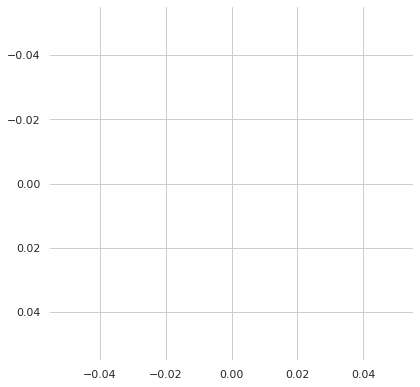

In [ ]:
sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)

sns.scatterplot(x=df["action_type"].value_counts(), y="result",
                #hue="clarity",
                palette="ch:r=-.2,d=.3_r",
                sizes=(8, 8), linewidth=0,
                data=df, ax=ax)

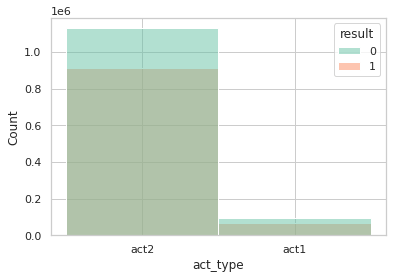

In [ ]:
 ax = sns.histplot(x="act_type", data=df,hue="result",palette="Set2")

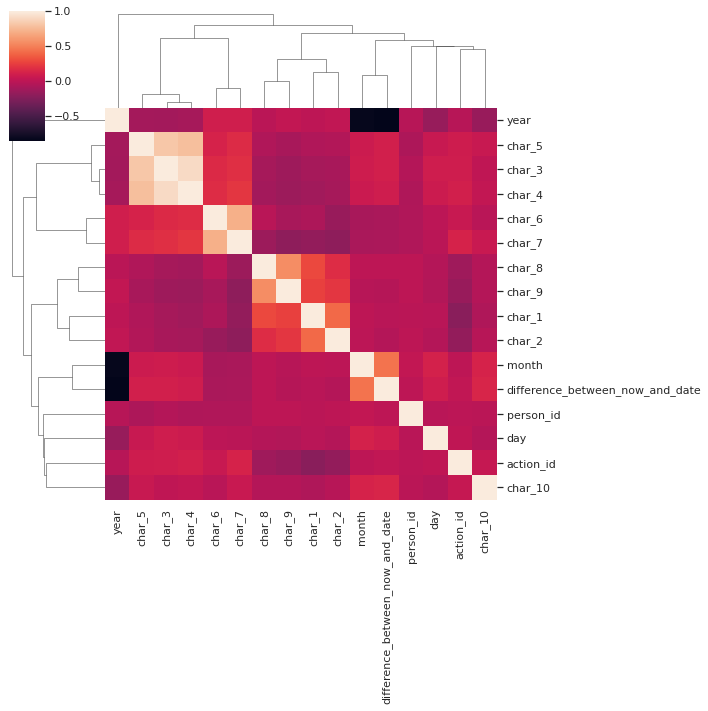

In [ ]:
corr_meat = df.corr(method='pearson')

# Customize the heatmap of the corr_meat correlation matrix
fig = sns.clustermap(corr_meat,
               row_cluster=True,
               col_cluster=True,
               figsize=(10, 10));

plt.setp(fig.ax_heatmap.xaxis.get_majorticklabels(), rotation=90);
plt.setp(fig.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);

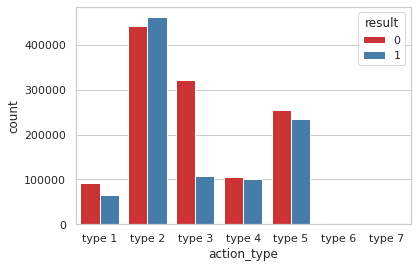

In [ ]:
 ax = sns.countplot(x="action_type", data=df,hue="result",palette="Set1")

Как мы видим type_3 имеет самое большое кол-во значений (со значением 0 и 1) и самыми малым кол-во значений обладает type 6 и type 7

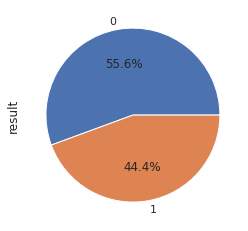

In [ ]:
df['result'].value_counts().plot(kind='pie', autopct='%1.1f%%',)

# Action test analysis

### Первый взгялд на датасет

In [ ]:
action_test.describe()

,person_id,action_id,date,action_type,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10
count,498687,498687,498687,498687,40092,40092,40092,40092,40092,40092,40092,40092,40092,458595
unique,37823,498687,411,7,48,31,11,7,6,5,8,18,19,3961
top,ppl_112017,act1_249281,2022-09-16,type 2,type 2,type 2,type 1,type 3,type 6,type 2,type 1,type 4,type 8,type 1
freq,1650,1,10302,223164,9862,12757,9927,25046,17131,15940,13290,19803,7888,223164


In [ ]:
action_test.isnull().sum() 

person_id           0
action_id           0
date                0
action_type         0
char_1         458595
char_2         458595
char_3         458595
char_4         458595
char_5         458595
char_6         458595
char_7         458595
char_8         458595
char_9         458595
char_10         40092
dtype: int64

### мердж action_test и person

In [ ]:
list_of_chars = ["char_1","char_2","char_3","char_4","char_5","char_6","char_7","char_8","char_9",'person_id']
test_df=action_test.merge(person[list_of_chars], on='person_id', how='inner')

In [ ]:
test_df

,person_id,action_id,date,action_type,char_1_x,char_2_x,char_3_x,char_4_x,char_5_x,char_6_x,...,char_10,char_1_y,char_2_y,char_3_y,char_4_y,char_5_y,char_6_y,char_7_y,char_8_y,char_9_y
0,ppl_100004,act1_249281,2022-07-20,type 1,type 5,type 10,type 5,type 1,type 6,type 1,...,NaN,type 2,type 3,type 40,type 25,type 9,type 4,type 16,type 2,type 2
1,ppl_100004,act2_230855,2022-07-20,type 5,NaN,NaN,NaN,NaN,NaN,NaN,...,type 682,type 2,type 3,type 40,type 25,type 9,type 4,type 16,type 2,type 2
2,ppl_10001,act1_240724,2022-10-14,type 1,type 12,type 1,type 5,type 4,type 6,type 1,...,NaN,type 2,type 3,type 6,type 6,type 4,type 1,type 1,type 2,type 2
3,ppl_10001,act1_83552,2022-11-27,type 1,type 20,type 10,type 5,type 4,type 6,type 1,...,NaN,type 2,type 3,type 6,type 6,type 4,type 1,type 1,type 2,type 2
4,ppl_10001,act2_1043301,2022-10-15,type 5,NaN,NaN,NaN,NaN,NaN,NaN,...,type 3015,type 2,type 3,type 6,type 6,type 4,type 1,type 1,type 2,type 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498682,ppl_99997,act2_4367092,2023-04-22,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,type 1,type 2,type 2,type 40,type 25,type 9,type 3,type 8,type 6,type 6
498683,ppl_99997,act2_4404220,2022-11-12,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,type 1,type 2,type 2,type 40,type 25,type 9,type 3,type 8,type 6,type 6
498684,ppl_99997,act2_448830,2022-08-02,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,type 1,type 2,type 2,type 40,type 25,type 9,type 3,type 8,type 6,type 6
498685,ppl_99997,act2_450133,2022-08-02,type 2,NaN,NaN,NaN,NaN,NaN,NaN,...,type 1,type 2,type 2,type 40,type 25,type 9,type 3,type 8,type 6,type 6


In [ ]:
test_df.isnull().sum() 

person_id           0
action_id           0
date                0
action_type         0
char_1_x       458595
char_2_x       458595
char_3_x       458595
char_4_x       458595
char_5_x       458595
char_6_x       458595
char_7_x       458595
char_8_x       458595
char_9_x       458595
char_10         40092
char_1_y            0
char_2_y            0
char_3_y            0
char_4_y            0
char_5_y            0
char_6_y            0
char_7_y            0
char_8_y            0
char_9_y            0
dtype: int64

In [ ]:
# уберем ненужный _x из наших колонок
test_df.columns = test_df.columns.str.replace('_x', '') 

In [ ]:
list_of_chars.pop()
for i in list_of_chars:
  test_df[i+""] = test_df[i+""].fillna(test_df[i+"_y"])

In [ ]:
# Избавимся от ненужных колонок, так как мы заполнили пропуски
test_df = test_df.iloc[: , :-9] 

In [ ]:
test_df.isnull().sum() 

person_id          0
action_id          0
date               0
action_type        0
char_1             0
char_2             0
char_3             0
char_4             0
char_5             0
char_6             0
char_7             0
char_8             0
char_9             0
char_10        40092
dtype: int64

In [ ]:
# Как мы видим, размер составляет больше 700 мб, поэтому давайте его сократим
test_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498687 entries, 0 to 498686
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   person_id    498687 non-null  object
 1   action_id    498687 non-null  object
 2   date         498687 non-null  object
 3   action_type  498687 non-null  object
 4   char_1       498687 non-null  object
 5   char_2       498687 non-null  object
 6   char_3       498687 non-null  object
 7   char_4       498687 non-null  object
 8   char_5       498687 non-null  object
 9   char_6       498687 non-null  object
 10  char_7       498687 non-null  object
 11  char_8       498687 non-null  object
 12  char_9       498687 non-null  object
 13  char_10      458595 non-null  object
dtypes: object(14)
memory usage: 458.0 MB


## Dataset set categories


In [ ]:
# to category
test_df['action_type'] = test_df['action_type'].astype('category')


In [ ]:
# to datetime
test_df['date'] = pd.to_datetime(test_df['date'])

In [ ]:
# Теперь,  чтобы избавиться от NaN мы заполним char_10 нулями
test_df["char_10"]=test_df["char_10"].fillna("type 0")

### Encoding data

In [ ]:
# Дабы избавиться от string значений, которые могут нам помешать, мы возьмем только числовые значения действий

def get_number_of_type(row):
  return row.split(" ")[1]

def get_number_and_act_of_action(row,idx):
  return row.split("_")[idx]

def get_number_of_person_id(row):
  return row.split("_")[1]

In [ ]:
# На данном шаге мы получаем только какой номер type у нас в колонке и записываем на это же место. Пример: (было) type 2	 -> (стало) 2
for i in range(1,11):
  test_df[f'char_{i}'] = test_df[f'char_{i}'].apply(get_number_of_type)
  test_df[f'char_{i}'] = test_df[f'char_{i}'].astype(float)

In [ ]:
# Здесь мы отбрасываем ppl_ так как нам важен id человека и стринговое значение может помешать анализу
test_df[f'person_id']=test_df['person_id'].apply(get_number_of_person_id)
test_df[f'person_id']=test_df['person_id'].astype('float')

Следующий шаг может вызвать вопросы, но давайте посмотрим для чего же это все нужно

На данном этапе совершается немного необычное действие. К примеру, мы разбиваем act2_1734928 на act2 и 1734928 . Сделано это для того, чтобы потом мы могли загнать эти данные в Encoder. Это может повлиять на производительность и на "точность" нашей модели

In [ ]:
test_df['act_type']=test_df['action_id'].apply(lambda x:get_number_and_act_of_action(x,0))
test_df['action_id']=test_df['action_id'].apply(lambda x:get_number_and_act_of_action(x,1))
test_df['action_id']= test_df['action_id'].astype('float')

Данный этап тоже стоит отдельного внимания... 

Дабы datetime тоже имел вес, его необходимо преобразовать, но, к сожалению, с форматом 2023-08-26 могут возникнуть проблемы, поэтому хорошей практикой считается использование методики разбиения на дни, месяцы и года, что здесь и выполняется !

In [ ]:
test_df['date']=pd.to_datetime(test_df['date'], format = '%Y-%m-%d')
timestemp_dt= test_df['date'].dt

test_df['day'] = timestemp_dt.day
test_df['month'] = timestemp_dt.month
test_df['year'] = timestemp_dt.year
test_df['difference_between_now_and_date'] = (datetime.today() - test_df['date']).dt.days

In [ ]:
test_df

,person_id,action_id,date,action_type,char_1,char_2,char_3,char_4,char_5,char_6,char_7,char_8,char_9,char_10,act_type,day,month,year,difference_between_now_and_date
0,100004.0,249281.0,2022-07-20,type 1,5.0,10.0,5.0,1.0,6.0,1.0,1.0,7.0,4.0,0.0,act1,20,7,2022,136
1,100004.0,230855.0,2022-07-20,type 5,2.0,3.0,40.0,25.0,9.0,4.0,16.0,2.0,2.0,682.0,act2,20,7,2022,136
2,10001.0,240724.0,2022-10-14,type 1,12.0,1.0,5.0,4.0,6.0,1.0,1.0,13.0,10.0,0.0,act1,14,10,2022,50
3,10001.0,83552.0,2022-11-27,type 1,20.0,10.0,5.0,4.0,6.0,1.0,1.0,5.0,5.0,0.0,act1,27,11,2022,6
4,10001.0,1043301.0,2022-10-15,type 5,2.0,3.0,6.0,6.0,4.0,1.0,1.0,2.0,2.0,3015.0,act2,15,10,2022,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
498682,99997.0,4367092.0,2023-04-22,type 2,2.0,2.0,40.0,25.0,9.0,3.0,8.0,6.0,6.0,1.0,act2,22,4,2023,-140
498683,99997.0,4404220.0,2022-11-12,type 2,2.0,2.0,40.0,25.0,9.0,3.0,8.0,6.0,6.0,1.0,act2,12,11,2022,21
498684,99997.0,448830.0,2022-08-02,type 2,2.0,2.0,40.0,25.0,9.0,3.0,8.0,6.0,6.0,1.0,act2,2,8,2022,123
498685,99997.0,450133.0,2022-08-02,type 2,2.0,2.0,40.0,25.0,9.0,3.0,8.0,6.0,6.0,1.0,act2,2,8,2022,123


In [ ]:
test_df.nunique()

person_id                           37823
action_id                          494801
date                                  411
action_type                             7
char_1                                 48
char_2                                 31
char_3                                 41
char_4                                 25
char_5                                  9
char_6                                  7
char_7                                 25
char_8                                 18
char_9                                 19
char_10                              3962
act_type                                2
day                                    31
month                                  12
year                                    2
difference_between_now_and_date       411
dtype: int64

In [ ]:
# Посмотрим как изменился размер нашего датасета
test_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 498687 entries, 0 to 498686
Data columns (total 19 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   person_id                        498687 non-null  float64       
 1   action_id                        498687 non-null  float64       
 2   date                             498687 non-null  datetime64[ns]
 3   action_type                      498687 non-null  category      
 4   char_1                           498687 non-null  float64       
 5   char_2                           498687 non-null  float64       
 6   char_3                           498687 non-null  float64       
 7   char_4                           498687 non-null  float64       
 8   char_5                           498687 non-null  float64       
 9   char_6                           498687 non-null  float64       
 10  char_7                           498687 non-

In [ ]:
test_df.isnull().sum() 

person_id                          0
action_id                          0
date                               0
action_type                        0
char_1                             0
char_2                             0
char_3                             0
char_4                             0
char_5                             0
char_6                             0
char_7                             0
char_8                             0
char_9                             0
char_10                            0
act_type                           0
day                                0
month                              0
year                               0
difference_between_now_and_date    0
dtype: int64

## Dataset visual

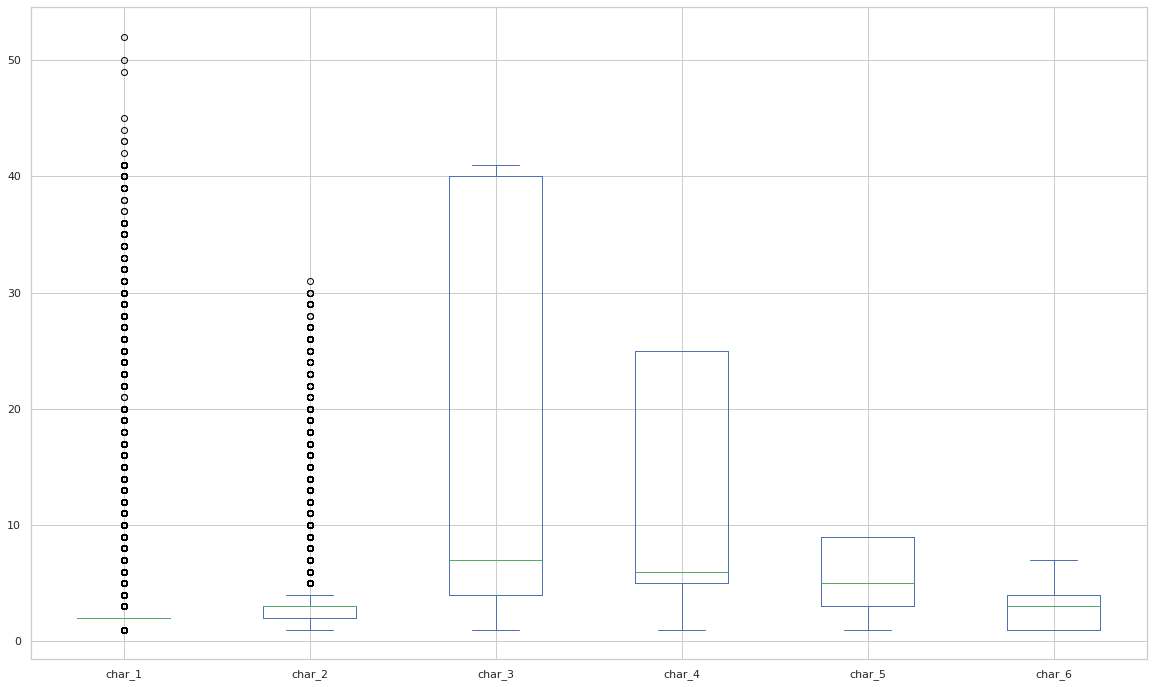

In [ ]:
test_df[['char_1','char_2','char_3','char_4','char_5','char_6']].plot(kind='box', figsize=(20,12))


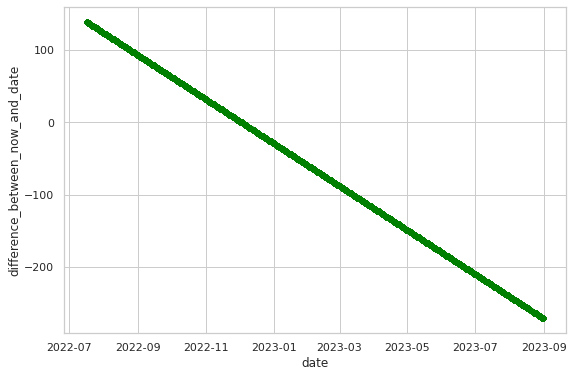

In [ ]:
test_df.plot(kind='scatter', x='date', y='difference_between_now_and_date', figsize=(9,6), color='Green')


# ML


Теперь, когда у нас готов датасет, мы можем начать наше обучение модели, но перед этим стоит обратить внимание на некоторые детали

Конечно же, мы можем запихнуть все колонки в LableEncoder и радоваться жизни, но даже в самой документации сказано, что данный "энкодер" нужен для target-а, поэтому мы оставим его для result

Остальные способы переобработки нам будут нужны для преобразования бинарных данных в колонках и иной нормализации

In [ ]:
label_encoder = LabelEncoder()
min_max_scaler = preprocessing.MinMaxScaler()
ordinal_encoder = preprocessing.OrdinalEncoder()
one_hot_encoder = preprocessing.OneHotEncoder(sparse=False)

for i in (df.columns):
    if (i=="result"):
      df[i]=label_encoder.fit_transform(df[i])
    elif (i=="person_id"):
      df[i]=min_max_scaler.fit_transform(df[[i]].values.reshape(-1, 1))
    elif (i=="act_type"):
      df[i]=one_hot_encoder.fit_transform(df[[i]])
    elif ( (i=="action_type") or (i=="difference_between_now_and_date") ):
      df[i]=ordinal_encoder.fit_transform(df[[i]])

In [ ]:
for i in (test_df.columns):
    if (i=="person_id"):
      test_df[i]=min_max_scaler.fit_transform(test_df[[i]].values.reshape(-1, 1))
    elif (i=="act_type"):
      test_df[i]=one_hot_encoder.fit_transform(test_df[[i]])
    elif ( (i=="action_type") or (i=="difference_between_now_and_date") ):
      test_df[i]=ordinal_encoder.fit_transform(test_df[[i]])

In [ ]:
# Удаляем date, так как больше нам эта колонка не нужна
test_df = test_df.drop(labels=['date'], axis=1)

In [ ]:
X = df.drop(labels=['result','date'], axis=1) # выбрасываем индекс, так как он никак не повлияет на наше исследование, результат, так как это таргер и дату, так как она у нас лежит преобразованная
y = df['result']
x_train , x_test , y_train , y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Пробный забег с RandomForest

Для начала давайте попробуем обучить наши данные на RandomForest и посмотреть какой будет наш конечный результат



In [ ]:
%%time
rf = RandomForestClassifier(max_features=len(X.columns),max_depth=15)
rf.fit(x_train , y_train)

CPU times: user 14min 27s, sys: 1.43 s, total: 14min 29s
Wall time: 14min 29s


RandomForestClassifier(max_depth=15, max_features=18)

In [ ]:
# проверим наш score на трейновом сете и на тестовом
print(rf.score(x_train , y_train)) 
print(rf.score(x_test , y_test))

0.8987707585252743
0.8893289926394291


<BarContainer object of 18 artists>

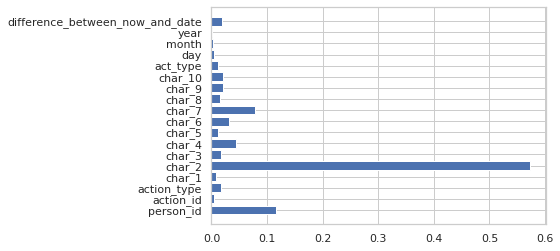

In [ ]:
# Посмотрим какая фича больше всего повлияла на прогнозы
plt.barh(X.columns, rf.feature_importances_)

Как мы видим, RandomForest нелохо справился со своей задачей, но почему бы не попробовать повысить точность ?

## Подбор гиперпараметров с Optuna

На данном этапе мы воспользуемся Optuna

Почему Optuna, а не что-то иное ? 

Всё на самом деле довольно-таки просто ! Если какой-нибудь GridSearchCV проверяет все возможные сочетания гиперпараметров, то Optuna использует байесевский подход, который отличается от RandomForestSearchCV тем, что он старается подбирать рандомные точки рядом с теми, которые дали прирост к качеству. 

Теперь, когда мы поняли почему мы используем Optuna, давайте же применим её и подберем гиперпараметры для catboost и lightGBM (тут бы мог стоять и xgboost, но он крайне прожорливый и медленный, но он тоже хорош в данных задачах)

К тому же, мы будем сохранять наши подборы\исследования, так что мы сможем ими воспользоваться позже. Для этого мы будем использовать joblib !

для начала мы пишем метод ***`objective`*** в котором у нас будут настройки нашей модели. Под настройками можно считать переменную `params`, в которой хранится словарь, где написаны значения, между которыми мы хотим, чтобы optuna выбирала и искала самые оптимальные значения.

После того, как optuna выбрала параметры, мы загоняем эти данные в модель, а после проверяем на сколько хорошо она справилась, а далее *мы возвращаем значение того, как хорошо она справилась*. Так мы будем искать максимальные по эффективности гиперпараметры для модели


## CatBoost

In [ ]:
def objective(trial,data=X,target=y):
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.3,random_state=42, stratify=y)
    cv_rf= StratifiedKFold(n_splits=5)

    param = {
        'verbose': False,
        'loss_function': trial.suggest_categorical('loss_function',['Logloss', 'CrossEntropy']),
        'eval_metric' : trial.suggest_categorical('eval_metric',['AUC']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1, 15),
        'bagging_temperature': trial.suggest_float('bagging_temperature',1.00001, 15), 
        'rsm': trial.suggest_float('rsm', 1e-6, 1.0),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1, 12), 
        'learning_rate': trial.suggest_float('learning_rate', 1e-7,1),
        'leaf_estimation_backtracking': trial.suggest_categorical('leaf_estimation_backtracking', ['No','AnyImprovement']),
        'depth': trial.suggest_int('depth',1, 12),
        'fold_len_multiplier': trial.suggest_float('fold_len_multiplier', 1, 9),
        'score_function': trial.suggest_categorical('score_function', ['Cosine', 'L2']),

        'boosting_type': trial.suggest_categorical('boosting_type', ['Ordered', 'Plain']),

        'langevin': trial.suggest_categorical('langevin', [True, False]),

        'iterations': trial.suggest_int('iterations', 2000, 5000),
    }

    if param['loss_function'] not in ["MultiCrossEntropy","MultiLogloss", 'CrossEntropy']:
      param['auto_class_weights']= trial.suggest_categorical('auto_class_weights', ['None','Balanced','SqrtBalanced'])

      if param["boosting_type"] == "Ordered":
        param['grow_policy']= 'SymmetricTree'

      if param["boosting_type"] == "Plain":
        param['grow_policy']= trial.suggest_categorical('grow_policy', ['SymmetricTree','Depthwise','Lossguide'])    


      if param["grow_policy"] != "Lossguide":
        param['sampling_frequency']= trial.suggest_categorical('sampling_frequency', ['PerTree','PerTreeLevel'])


      if param["langevin"]==True:
        param["posterior_sampling"] = trial.suggest_categorical('posterior_sampling', [True, False])
      
        if param["posterior_sampling"] == True:
          param['model_shrink_mode']= 'Constant'

        else:
          param['model_shrink_mode']= trial.suggest_categorical('model_shrink_mode', ['Constant', 'Decreasing'])

    model = cb.CatBoostClassifier(**param)  
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=500,verbose=False)

    preds = model.predict(test_x)
    pred_labels = np.rint(preds)
    accuracy = roc_auc_score(test_y, pred_labels)
    print(accuracy , param['loss_function'])
    
    joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/Sberseasons/catboost_sber.pkl')

    return (cross_val_score(model, test_x, test_y, cv = cv_rf, scoring = 'roc_auc')).mean() 

In [ ]:
def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            "\nWarning\nTrial {} finished with best value: {} and parameters: {}.\n ".format(
            frozen_trial.number,
            frozen_trial.value,
            frozen_trial.params,
            )
        )

In [ ]:
%%time
if os.path.isfile('/content/drive/MyDrive/Colab Notebooks/Sberseasons/catboost_sber.pkl'):
  study = joblib.load('/content/drive/MyDrive/Colab Notebooks/Sberseasons/catboost_sber.pkl')
else:
    sampler = optuna.samplers.TPESampler(multivariate=True, warn_independent_sampling=False)
    study = optuna.create_study(direction='maximize', load_if_exists=True,sampler=sampler)

study.optimize(objective, n_trials=1_000, gc_after_trial=True,
              show_progress_bar=True, n_jobs=-1, callbacks=[logging_callback])
joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/Sberseasons/catboost_sber.pkl')

Пока Optuna работает, давайте просмотрим, что было сделано и для чего:

`joblib` в ***`objective`*** нужен для того, чтобы мы обновляли результаты наших исследований. Таким образом, если вдруг наш поиск прервется, мы не потеряем данные нашего исследования. 

Далее, ***`logging_callback`*** позволяет выводить сообщение о том, что "сейчас был удачный показатель". Этот метод нужен, скорее, для визуальной составляющей

3 ячейка отвечает за несколько важных фичей. Во-первых, она смотрит, было ли до этого исследование (которое мы сохраняли с помощью joblib) и если таково было, то продолжить оттуда, где остановилась. Если же исследования не было, то она запустит исследование по новой.
Во-вторых, у нас имеется *`TPESampler`*, которые и отвечает за байесевский подход и позволяет лучше подбирать параметры.

Наверняка вы заметили, что в `study` есть `n_trials`, который показывает сколько раз нужно optuna прогнать исследования до того, как прекратить этот поиск. Можно ставить какие угодно высокие значения, так как мы сохраняем наши исследования и в любой удобный момент мы можем остановить поиск и идти дальше по данным

In [ ]:
study = joblib.load('/content/drive/MyDrive/Colab Notebooks/Sberseasons/catboost_sber.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_edf(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
Best_trial = study.best_trial.params
Best_trial

{'loss_function': 'CrossEntropy',
 'eval_metric': 'AUC',
 'min_data_in_leaf': 4,
 'bagging_temperature': 3.863457351624216,
 'rsm': 0.3816739236806296,
 'leaf_estimation_iterations': 9,
 'learning_rate': 0.3041226562252205,
 'leaf_estimation_backtracking': 'No',
 'depth': 10,
 'fold_len_multiplier': 3.472225998977523,
 'score_function': 'L2',
 'boosting_type': 'Plain',
 'langevin': True,
 'iterations': 4368}

In [ ]:
study.best_trial.value

0.9820710835153456

In [ ]:
model = cb.CatBoostClassifier()

In [ ]:
model.set_params(**study.best_params)
model.fit(X, y, verbose=False)

Text(0.5, 1.0, 'Feature Importance')

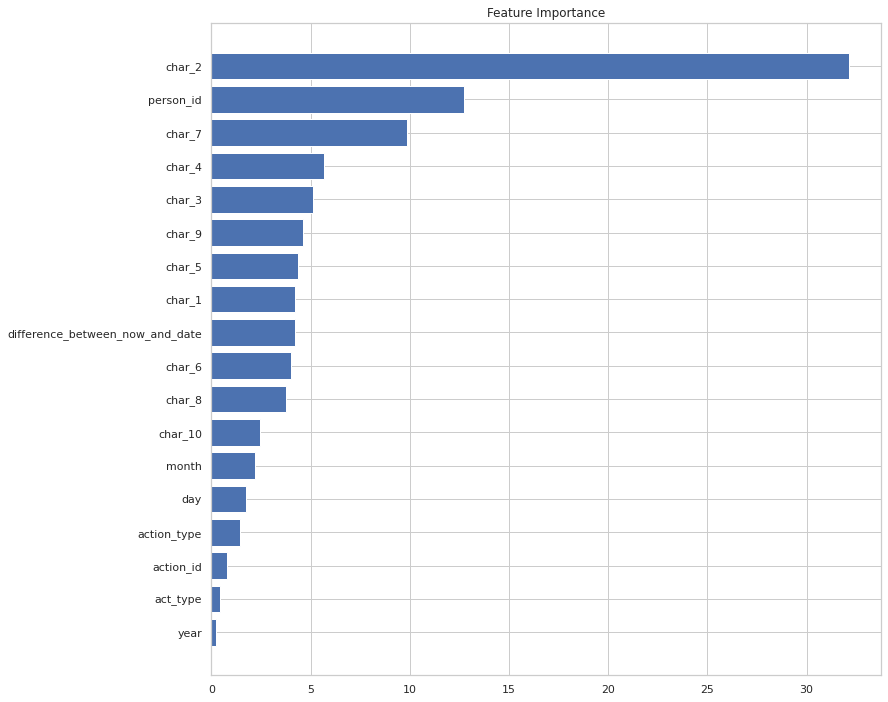

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_test.columns)[sorted_idx])
plt.title('Feature Importance')

### Кросс валидация

Для кросс валидации мы воспользуемся разделением нашего датасета на 10 штук. (На практике же всегда используют 5 или 10 разделений). Почему именно 5 или 10 написано здесь - 
"The choice of k is usually 5 or 10, but there is no formal rule. As k gets larger, the difference in size between the training set and the resampling subsets gets smaller. As this difference decreases, the bias of the technique becomes smaller"

— Page 70, Applied Predictive Modeling, 2013.

In [ ]:
# Повторим тоже самое, но уже со StratifiedKFold
cv_rf= StratifiedKFold(n_splits=10)
res = cross_val_score(model, x_test, y_test, cv = cv_rf, scoring = 'roc_auc')
print(f'Best value cross val: {study.best_value} \nTest score:  {res.mean()}' )

### Проверка с помощью eli5

Библиотека eli5 помогает нам лучше понять обученные модели о том, почему они делают тот или иной прогноз на конкретной выборке. Это может помочь нам лучше понять нашу модель, чтобы узнать о важных функциях, а также о надежности модели.

In [ ]:
perm = PermutationImportance(model, random_state=1).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = x_test.columns.tolist())

Weight,Feature
0.3122 ± 0.0009,char_2
0.1457 ± 0.0004,char_7
0.1171 ± 0.0006,person_id
0.0945 ± 0.0004,char_6
0.0633 ± 0.0003,char_3
0.0609 ± 0.0004,char_4
0.0597 ± 0.0002,char_9
0.0554 ± 0.0003,char_5
0.0553 ± 0.0003,char_1
0.0476 ± 0.0004,char_8


### предсказывание результата

In [ ]:
res_for_pred = model.predict(test_df)

In [ ]:
res_for_pred_proba = model.predict_proba(test_df)[:, 1]

In [ ]:
res_for_pred_proba

array([4.99303009e-01, 5.44328387e-01, 4.97401267e-01, ...,
       1.16886252e-06, 1.16886252e-06, 9.34332928e-08])

In [ ]:
action_test = pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Sberseasons/action_test.csv') 

sber_result_catboost = action_test[['action_id']]
sber_result_catboost.head()

,action_id
0,act1_249281
1,act2_230855
2,act1_240724
3,act1_83552
4,act2_1043301


In [ ]:
sber_result_catboost['result']=res_for_pred_proba
sber_result_catboost.head()

<ipython-input-154-bdd7e2ef55f7>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,action_id,result
0,act1_249281,0.499303
1,act2_230855,0.544328
2,act1_240724,0.497401
3,act1_83552,0.845376
4,act2_1043301,0.979144


In [ ]:
sber_result_catboost.to_csv("sber_result_catboost.csv", sep=';', encoding='utf-8', index=False)


### Feature Selection

Приведу несколько примеров, как можно улучшить качество модели, используя feature selection и не только.
Примечание - в коллабе данные функции выполняются долго

In [ ]:
cv_rf= StratifiedKFold(n_splits=5)
select_df = pd.DataFrame(columns = ['Train_score', 'KBest', 'Score_KBest', 'std', '%'])
for i in range(1, x_test.shape[1]+1):
  Xx = SelectKBest(f_classif, k=i).fit_transform(x_test, y_test)
  res = cross_val_score(model, Xx, y_test, cv = cv_rf, scoring = 'roc_auc')
  select_df = select_df.append({'Train_score': study.best_value,
                                'KBest': i, 'Score_KBest': res.mean(),
                                'std': res.std(),
                                '%': round(res.mean()*100/ study.best_value, 2)},
                               ignore_index=True)
select_df

### Wrapper method 


В самом лучшем случае необходимо использовать wrapper methods feature selection - перебор кобминаций признаков внутри самой модели, выигрывая при этом на качестве результов, но проигрывая во времени исполнения и расчетов. Данный вариант я не стал просчитывать, потому что это слишком затратный вариант по времени.

In [ ]:
feat_sel = EFS(estimator=model, 
                   min_features=1,
                   max_features=x_test.shape[1],
                   scoring='roc_auc',
                   print_progress=True,
                   clone_estimator=False,
                   cv=5)
feat_sel.fit_transform(x_test, y_test)

Выходные данные были обрезаны до нескольких последних строк (5000).
2792:	total: 3m 59s	remaining: 2m 15s
2793:	total: 3m 59s	remaining: 2m 14s
2794:	total: 3m 59s	remaining: 2m 14s
2795:	total: 3m 59s	remaining: 2m 14s
2796:	total: 3m 59s	remaining: 2m 14s
2797:	total: 3m 59s	remaining: 2m 14s
2798:	total: 3m 59s	remaining: 2m 14s
2799:	total: 4m	remaining: 2m 14s
2800:	total: 4m	remaining: 2m 14s
2801:	total: 4m	remaining: 2m 14s
2802:	total: 4m	remaining: 2m 14s
2803:	total: 4m	remaining: 2m 14s
2804:	total: 4m	remaining: 2m 13s
2805:	total: 4m	remaining: 2m 13s
2806:	total: 4m	remaining: 2m 13s
2807:	total: 4m	remaining: 2m 13s
2808:	total: 4m	remaining: 2m 13s
2809:	total: 4m	remaining: 2m 13s
2810:	total: 4m	remaining: 2m 13s
2811:	total: 4m 1s	remaining: 2m 13s
2812:	total: 4m 1s	remaining: 2m 13s
2813:	total: 4m 1s	remaining: 2m 13s
2814:	total: 4m 1s	remaining: 2m 13s
2815:	total: 4m 1s	remaining: 2m 13s
2816:	total: 4m 1s	remaining: 2m 12s
2817:	total: 4m 1s	remaining: 2m 12s

In [ ]:
feat_sel.best_score_

## LightGBM

In [ ]:
def objective(trial,data=X,target=y):   
    
    train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.3,random_state=42, stratify=y)
    cv_rf= StratifiedKFold(n_splits=5)

    param = {
        "objective": trial.suggest_categorical("objective",["binary","cross_entropy"]),
        "n_estimators": trial.suggest_int("n_estimators",2000, 7000),
        "metric": 'auc',
        "num_threads" : 2,
        'learning_rate': trial.suggest_float('learning_rate', 1e-7,1),
        "num_leaves": trial.suggest_int("num_leaves", 40, 4000, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 100, step=1),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=1),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=1),
        'min_child_weight': trial.suggest_float('min_child_samples', 0.1,round(X.shape[0]/1000,1), step = 0.1),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.2, 0.9, step=0.1),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.2, 0.9, step=0.1
        ),


    }

    model = lgbm.LGBMClassifier(**param,random_state = 42)
    model.fit(train_x,train_y,eval_set=[(test_x,test_y)],early_stopping_rounds=500,verbose=False)

    preds = model.predict(test_x)
    pred_labels = np.rint(preds)
    accuracy = roc_auc_score(test_y, pred_labels)
    print(accuracy , param['objective'])
    
    joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/Sberseasons/lgbm_sber.pkl')

    return (cross_val_score(model, test_x, test_y, cv = cv_rf, scoring = 'roc_auc')).mean() 

In [ ]:
def logging_callback(study, frozen_trial):
    previous_best_value = study.user_attrs.get("previous_best_value", None)
    if previous_best_value != study.best_value:
        study.set_user_attr("previous_best_value", study.best_value)
        print(
            "\nWarning\nTrial {} finished with best value: {} and parameters: {}.\n ".format(
            frozen_trial.number,
            frozen_trial.value,
            frozen_trial.params,
            )
        )

In [ ]:
%%time
if os.path.isfile('/content/drive/MyDrive/Colab Notebooks/Sberseasons/lgbm_sber.pkl'):
  study = joblib.load('/content/drive/MyDrive/Colab Notebooks/Sberseasons/lgbm_sber.pkl')
else:
    sampler = optuna.samplers.TPESampler(multivariate=True, warn_independent_sampling=False)
    study = optuna.create_study(direction='maximize', load_if_exists=True,sampler=sampler)

study.optimize(objective, n_trials=1_000, gc_after_trial=True,
              show_progress_bar=True, n_jobs=-1, callbacks=[logging_callback])
joblib.dump(study, '/content/drive/MyDrive/Colab Notebooks/Sberseasons/lgbm_sber.pkl')

/usr/local/lib/python3.7/dist-packages/optuna/samplers/_tpe/sampler.py:284: ExperimentalWarning: ``multivariate`` option is an experimental feature. The interface can change in the future.
  ExperimentalWarning,
[I 2022-11-29 11:28:51,564] A new study created in memory with name: no-name-a42be697-5f49-4b75-8d76-5e93421b8a34
/usr/local/lib/python3.7/dist-packages/optuna/progress_bar.py:49: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/1000 [00:00<?, ?it/s]

0.8543748271511635 binary
0.8814033268701494 binary
[I 2022-11-29 12:13:55,222] Trial 1 finished with value: 0.9099164438847407 and parameters: {'objective': 'binary', 'n_estimators': 2724, 'learning_rate': 0.042827650621915785, 'num_leaves': 840, 'max_depth': 3, 'min_data_in_leaf': 55, 'lambda_l1': 91, 'lambda_l2': 29, 'min_child_samples': 2113.5, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}. Best is trial 1 with value: 0.9099164438847407.

Warning
Trial 1 finished with best value: 0.9099164438847407 and parameters: {'objective': 'binary', 'n_estimators': 2724, 'learning_rate': 0.042827650621915785, 'num_leaves': 840, 'max_depth': 3, 'min_data_in_leaf': 55, 'lambda_l1': 91, 'lambda_l2': 29, 'min_child_samples': 2113.5, 'bagging_fraction': 0.4, 'bagging_freq': 1, 'feature_fraction': 0.8}.
 
[I 2022-11-29 12:22:18,590] Trial 0 finished with value: 0.9284106468756885 and parameters: {'objective': 'binary', 'n_estimators': 2807, 'learning_rate': 0.6110210407715233,

In [ ]:
study = joblib.load('/content/drive/MyDrive/Colab Notebooks/Sberseasons/lgbm_sber.pkl')

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_edf(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
Best_trial = study.best_trial.params
Best_trial

{'objective': 'binary',
 'n_estimators': 4311,
 'learning_rate': 0.9200791736564645,
 'num_leaves': 460,
 'max_depth': 7,
 'min_data_in_leaf': 100,
 'lambda_l1': 45,
 'lambda_l2': 35,
 'min_child_samples': 167.3,
 'bagging_fraction': 0.7,
 'bagging_freq': 1,
 'feature_fraction': 0.7}

In [ ]:
study.best_trial.value

0.9573166507678904

In [ ]:
model = lgbm.LGBMClassifier()

In [ ]:
%%time
model.set_params(**study.best_params)
model.fit(X, y)

CPU times: user 26min 23s, sys: 2.9 s, total: 26min 26s
Wall time: 26min 26s


LGBMClassifier(bagging_fraction=0.7, bagging_freq=1, feature_fraction=0.7,
               lambda_l1=45, lambda_l2=35, learning_rate=0.9200791736564645,
               max_depth=7, min_child_samples=167.3, min_data_in_leaf=100,
               n_estimators=4311, num_leaves=460, objective='binary')

Text(0.5, 1.0, 'Feature Importance')

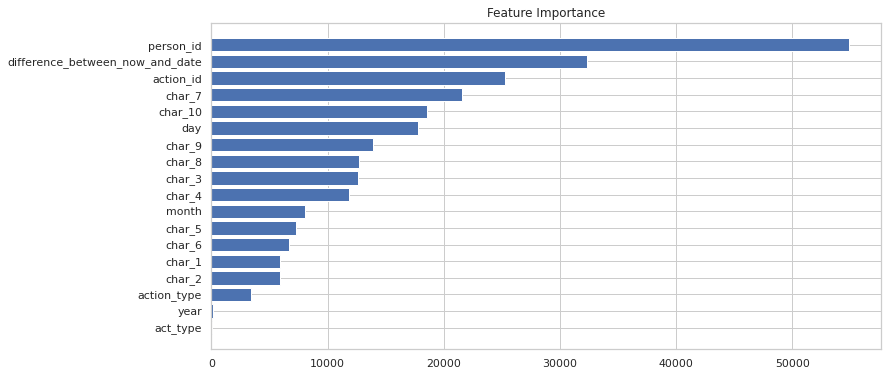

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_test.columns)[sorted_idx])
plt.title('Feature Importance')

### Кросс валидация

In [ ]:
# Повторим тоже самое, но уже со StratifiedKFold
cv_rf= StratifiedKFold(n_splits=10)
res = cross_val_score(model, x_test, y_test, cv = cv_rf, scoring = 'roc_auc')
print(f'Best value cross val: {study.best_value} \nTest score:  {res.mean()}' )

### Проверка с помощью eli5

Библиотека eli5 помогает нам лучше понять обученные модели о том, почему они делают тот или иной прогноз на конкретной выборке. Это может помочь нам лучше понять нашу модель, чтобы узнать о важных функциях, а также о надежности модели.

In [ ]:
perm = PermutationImportance(model, random_state=1).fit(x_test, y_test)
eli5.show_weights(perm, feature_names = x_test.columns.tolist())

### предсказывание результата

In [ ]:
res_for_pred = model.predict(test_df)

In [ ]:
res_for_pred_proba = model.predict_proba(test_df)[:, 1]

In [ ]:
res_for_pred_proba

array([4.58825270e-01, 4.78495944e-01, 3.22348510e-01, ...,
       1.06921599e-04, 1.06921599e-04, 1.79389928e-05])

In [ ]:
sber_result_lightGMB = test_df[['action_id']]
sber_result_lightGMB.head()

,action_id
0,249281.0
1,230855.0
2,240724.0
3,83552.0
4,1043301.0


In [ ]:
sber_result_lightGMB['result']=res_for_pred_proba
sber_result_lightGMB.head()

<ipython-input-86-ba59c0307939>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,action_id,result
0,249281.0,0.458825
1,230855.0,0.478496
2,240724.0,0.322349
3,83552.0,0.642798
4,1043301.0,0.994029


In [ ]:
sber_result_lightGMB.to_csv("sber_result_LightGBM.csv", sep=';', encoding='utf-8')


### Feature Selection

Приведу несколько примеров, как можно улучшить качество модели, используя feature selection, что может занять больше неск часов...

In [ ]:
cv_rf= StratifiedKFold(n_splits=5)
select_df = pd.DataFrame(columns = ['Train_score', 'KBest', 'Score_KBest', 'std', '%'])
for i in range(1, x_test.shape[1]+1):
  Xx = SelectKBest(f_classif, k=i).fit_transform(x_test, y_test)
  res = cross_val_score(model, Xx, y_test, cv = cv_rf, scoring = 'roc_auc')
  select_df = select_df.append({'Train_score': study.best_value,
                                'KBest': i, 'Score_KBest': res.mean(),
                                'std': res.std(),
                                '%': round(res.mean()*100/ study.best_value, 2)},
                               ignore_index=True)
select_df

### Wrapper method 


В самом лучшем случае необходимо использовать wrapper methods feature selection - перебор кобминаций признаков внутри самой модели, выигрывая при этом на качестве результов, но проигрывая во времени исполнения и расчетов. Данный вариант я не стал просчитывать, потому что это слишком затратный вариант по времени.

In [ ]:
feat_sel = EFS(estimator=model, 
                   min_features=1,
                   max_features=x_test.shape[1],
                   scoring='roc_auc',
                   print_progress=True,
                   clone_estimator=False,
                   cv=5)
feat_sel.fit_transform(x_test, y_test)

In [ ]:
feat_sel.best_score_

## Что ещё можно реализовать?
 1. сделать более углубленный анализ EDA, отыскать пары, тройки признаков, которые могут повлиять на предсказание нашей модели 
 2. Добавить ещё больше кастомных признаков, через объединение признаков, использование полиномиальных распределений 
 3. Добавить Feature selector, который будет работать внутри модели (wrappers Methods) например, Executive feature selector, но это требует времени, в котором я ограничен 
 4. Использовать доп модели для улучшения предсказания на части признаков, в работе будет выявлена эмпирическая связь признаков и таргета, на которой можно попробовать отдельно строить модель SVM
 5. Увеличить кол-во запусков trial у оптуны, так как при таком кол-во подбора параметров заявленного числа не хватает 
 6. Уменьшить learning rate у lgbm 
 7. Протестировать catboost classifier